In [65]:
import warnings
warnings.filterwarnings('ignore')
import re
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.mpl_style = 'default'
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
from util3 import *

In [2]:
# df = pd.read_csv('./df_start_over.csv', encoding='ISO-8859-1', index_col=0)

## Load Files

In [35]:
df_train = pd.read_csv('./data/train.csv', encoding='ISO-8859-1')
df_test = pd.read_csv('./data/test.csv', encoding='ISO-8859-1')
df_desp = pd.read_csv('./data/product_descriptions.csv')
df_attr = pd.read_csv('./data/attributes.csv')

df_brand = df_attr[df_attr.name == 'MFG Brand Name'][['product_uid', 'value']].rename(columns={'value': 'brand'})
num_train = df_train.shape[0]

df = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df = pd.merge(df, df_desp, how='left', on='product_uid')
df = pd.merge(df, df_brand, how='left', on='product_uid')
df['brand'].fillna('NOBRAND', inplace=True)

In [117]:
df['majority_relevance'] = df['relevance'].map(lambda x: x in [1.0, 1.33, 1.67, 2.0, 2.33, 2.67, 3.0])
def majoritize(df):
    return df[df['majority_relevance'] == 1]

## Fix Typos

In [36]:
df['search_term'] = df['search_term'].map(correct_typo)

## Stemming & Tokenizing

In [37]:
df['search_term'] = df['search_term'].map(lambda x: str_stem(x))
df['product_title'] = df['product_title'].map(lambda x: str_stem(x))
df['product_description'] = df['product_description'].map(lambda x: str_stem(x))
df['brand'] = df['brand'].map(lambda x: str_stem(x))

In [22]:
df['tokens_search_term'] = df['search_term'].map(lambda x: word_tokenize(x))
df['tokens_product_title'] = df['product_title'].map(lambda x: word_tokenize(x))
df['tokens_product_description'] = df['product_description'].map(lambda x: word_tokenize(x))
df['tokens_brand'] = df['brand'].map(lambda x: word_tokenize(x))

LookupError: 
**********************************************************************
  Resource 'tokenizers/punkt/english.pickle' not found.  Please
  use the NLTK Downloader to obtain the resource:  >>>
  nltk.download()
  Searched in:
    - 'C:\\Users\\USER/nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'C:\\Anaconda3\\nltk_data'
    - 'C:\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\USER\\AppData\\Roaming\\nltk_data'
    - ''
**********************************************************************

In [83]:
df['tokens_search_term'] = df['search_term'].map(lambda x: x.split())
df['tokens_product_title'] = df['product_title'].map(lambda x: x.split())
df['tokens_product_description'] = df['product_description'].map(lambda x: x.split())
df['tokens_brand'] = df['brand'].map(lambda x: x.split())

In [20]:
# df.to_csv('./df_aftering_stemming_and_tokenizing.csv')

## Meta-Features

In [2]:
# df = pd.read_csv('./df_aftering_stemming_and_tokenizing.csv', encoding='ISO-8859-1', index_col=0)

### Length

In [84]:
df['len_search_term'] = df['tokens_search_term'].map(lambda x: len(x))
df['len_product_title'] = df['tokens_product_title'].map(lambda x: len(x))
df['len_product_description'] = df['tokens_product_description'].map(lambda x: len(x))
df['len_brand'] = df['tokens_brand'].map(lambda x: len(x))

### Flag & Count & Ratio

In [141]:
df['flag_st_in_pt'] = df.apply(lambda x: int(x['search_term'] in x['product_title']), axis=1)
df['flag_st_in_pd'] = df.apply(lambda x: int(x['search_term'] in x['product_description']), axis=1)
df['flag_st_in_br'] = df.apply(lambda x: int(x['search_term'] in x['brand']), axis=1)

In [142]:
df['num_st_in_pt'] = \
    df.apply(lambda x: len(set(x['tokens_search_term']).intersection(set(x['tokens_product_title']))), axis=1)
df['num_st_in_pd'] = \
    df.apply(lambda x: len(set(x['tokens_search_term']).intersection(set(x['tokens_product_description']))), axis=1)
df['num_st_in_br'] = \
    df.apply(lambda x: len(set(x['tokens_search_term']).intersection(set(x['tokens_brand']))), axis=1)

In [144]:
df['ratio_st_in_pt'] = \
    df.apply(lambda x: x['num_st_in_pt'] / float(x['len_search_term']), axis=1)
df['ratio_st_in_pd'] = \
    df.apply(lambda x: x['num_st_in_pd'] / float(x['len_search_term']), axis=1)
df['ratio_st_in_br'] = \
    df.apply(lambda x: x['num_st_in_br'] / float(x['len_search_term']), axis=1)

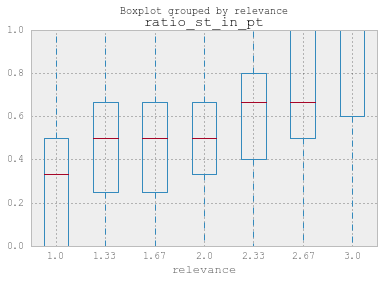

In [145]:
majoritize(df).boxplot(column='ratio_st_in_pt', by='relevance')

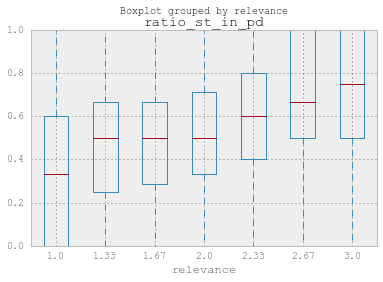

In [147]:
majoritize(df).boxplot(column='ratio_st_in_pd', by='relevance')

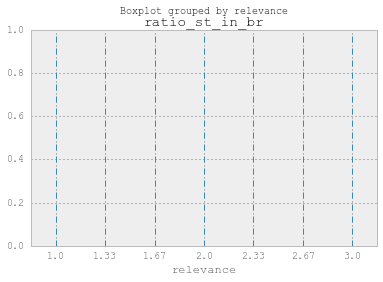

In [148]:
# not very useful
majoritize(df).boxplot(column='ratio_st_in_br', by='relevance')

### Encode Brand Feature

In [90]:
brands = pd.unique(df.brand.ravel())
brand_encoder = {}
index = 1000
for brand in brands:
    brand_encoder[brand] = index
    index += 10
brand_encoder['nobrand'] = 500

In [91]:
df['brand_encoded'] = df['brand'].map(lambda x: brand_encoder.get(x, 500))

### Encode Attributes Feature

In [99]:
pids_with_attr = pd.unique(df_attr.product_uid.ravel())
attr_encoder = {}
for pid in pids_with_attr:
    attr_encoder[pid] = 1

In [100]:
df['flag_has_attr'] = df['product_uid'].map(lambda x: attr_encoder.get(x, 0))

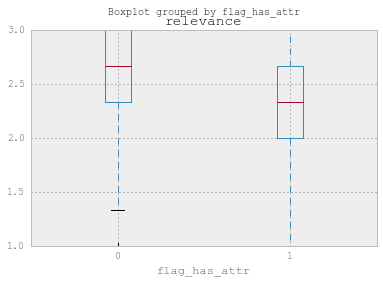

In [132]:
majoritize(df).boxplot(column='relevance', by='flag_has_attr')

## Text Similarities

### BOW

### TF-IDF

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel
tsvd = TruncatedSVD(n_components=10, random_state=2016)

#### ST - PT & ST - PD based on ST

In [233]:
tiv_from_st = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
tiv_from_st.fit(df['search_term'])
tiv_of_st_from_st = tiv_from_st.transform(df['search_term'])
tiv_of_pt_from_st = tiv_from_st.transform(df['product_title'])
tiv_of_pd_from_st = tiv_from_st.transform(df['product_description'])

In [241]:
tiv_cos_sim_st_pt_from_st = []
for idx in range(tiv_of_st_from_st.shape[0]):
    if idx % 10000 == 0:
        print(idx)
    tiv_cos_sim_st_pt_from_st.append(linear_kernel(tiv_of_st_from_st[idx], tiv_of_pt_from_st[idx])[0][0])
df['tiv_cos_sim_st_pt_from_st'] = tiv_cos_sim_st_pt_from_st

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


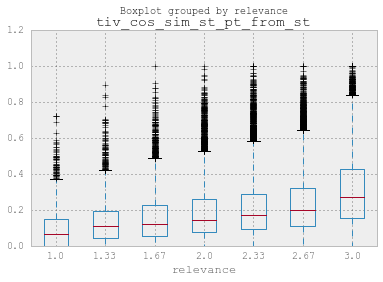

In [245]:
majoritize(df).boxplot(column='tiv_cos_sim_st_pt_from_st', by='relevance')

In [246]:
tiv_cos_sim_st_pd_from_st = []
for idx in range(tiv_of_st_from_st.shape[0]):
    if idx % 10000 == 0:
        print(idx)
    tiv_cos_sim_st_pd_from_st.append(linear_kernel(tiv_of_st_from_st[idx], tiv_of_pd_from_st[idx])[0][0])
df['tiv_cos_sim_st_pd_from_st'] = tiv_cos_sim_st_pd_from_st

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000


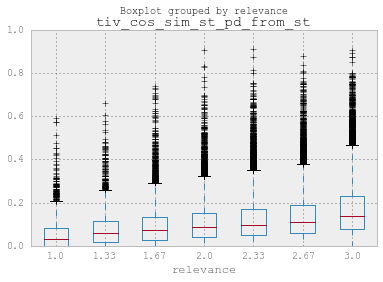

In [247]:
majoritize(df).boxplot(column='tiv_cos_sim_st_pd_from_st', by='relevance')

#### ST - PT based on PT

In [42]:
tiv_from_pt = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
tiv_from_pt.fit(df['product_title'])
tiv_of_pt_from_pt = tiv_from_pt.transform(df['product_title'])
tiv_of_st_from_pt = tiv_from_pt.transform(df['search_term'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [59]:
tiv_cos_sim_st_pt_from_pt = []
for idx in range(tiv_of_st_from_pt.shape[0]):
    if idx % 1000 == 0:
        print(idx)
    tiv_cos_sim_st_pt.append(linear_kernel(tiv_of_st_from_pt[idx], tiv_of_pt_from_pt[idx])[0][0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [107]:
df['tiv_cos_sim_st_pt_from_pt'] = tiv_cos_sim_st_pt_from_pt

NameError: name 'tiv_cos_sim_st_pt_from_pt' is not defined

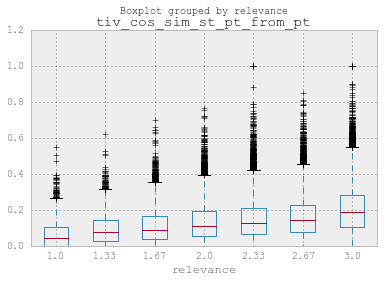

In [118]:
majoritize(df).boxplot(column='tiv_cos_sim_st_pt_from_pt', by='relevance')

#### ST - PT based on PT

In [ ]:
tiv_from_pd = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
tiv_from_pd.fit(df['product_description'])
tiv_of_pd_from_pd = tiv_from_pd.transform(df['product_description'])
tiv_of_st_from_pd = tiv_from_pd.transform(df['search_term'])

In [73]:
tiv_cos_sim_st_pd_from_pd = []
for idx in range(tiv_of_st_from_pd.shape[0]):
    if idx % 1000 == 0:
        print(idx)
    tiv_cos_sim_st_pd.append(linear_kernel(tiv_of_st_from_pd[idx], tiv_of_pd_from_pd[idx])[0][0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [128]:
df['tiv_cos_sim_st_pd_from_pd'] = tiv_cos_sim_st_pd_from_pd

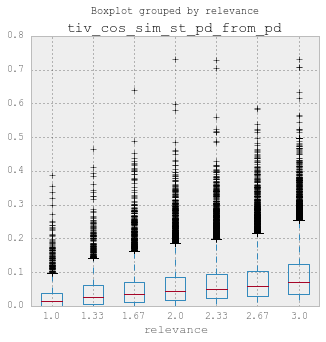

In [130]:
majoritize(df).boxplot(column='tiv_cos_sim_st_pd_from_pd', by='relevance', figsize=(5, 5))

### Jaccard

In [80]:
def jaccard(A, B):
    C = A.intersection(B)
    return float(len(C)) / (len(A) + len(B) - len(C))

In [103]:
df['jaccard_st_pt'] = df.apply(lambda x: jaccard(set(x['tokens_search_term']), set(x['tokens_product_title'])), axis=1)
df['jaccard_st_pd'] = df.apply(lambda x: jaccard(set(x['search_term']), set(x['product_description'])), axis=1)    
df['jaccard_st_br'] = df.apply(lambda x: jaccard(set(x['search_term']), set(x['brand'])), axis=1) 

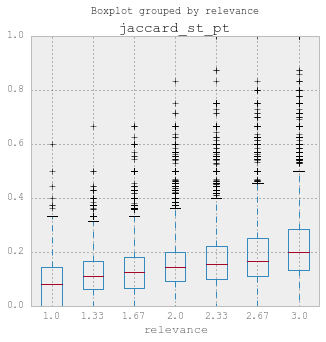

In [123]:
majoritize(df).boxplot(column='jaccard_st_pt', by='relevance', figsize=(5, 5))

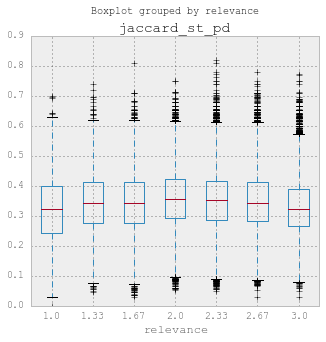

In [124]:
# not very useful
majoritize(df).boxplot(column='jaccard_st_pd', by='relevance', figsize=(5, 5))

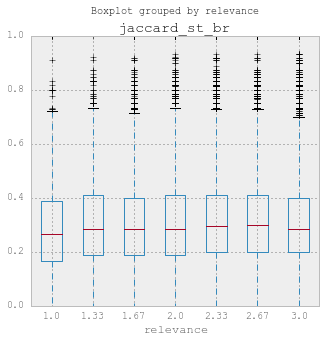

In [125]:
# not very useful
majoritize(df).boxplot(column='jaccard_st_br', by='relevance', figsize=(5, 5))

### Edit Distance

In [ ]:
from nltk.metrics import edit_distance

## tSVD

In [224]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
tsvd = TruncatedSVD(n_components=20, random_state=2016)

In [225]:
st_tfidf_tsvd = tsvd.fit_transform(tfidf.fit_transform(df['search_term']))
for i in range(st_tfidf_tsvd.shape[1]):
    df['st_tfidf_tsvd_'+str(i)] = st_tfidf_tsvd[:,i]

In [226]:
pt_tfidf_tsvd = tsvd.fit_transform(tfidf.fit_transform(df['product_title']))
for i in range(pt_tfidf_tsvd.shape[1]):
    df['pt_tfidf_tsvd_'+str(i)] = pt_tfidf_tsvd[:,i]

In [227]:
pd_tfidf_tsvd = tsvd.fit_transform(tfidf.fit_transform(df['product_description']))
for i in range(pd_tfidf_tsvd.shape[1]):
    df['pd_tfidf_tsvd_'+str(i)] = pd_tfidf_tsvd[:,i]

### tSVD based Cosine Similarity

In [210]:
from sklearn.metrics.pairwise import cosine_similarity

In [228]:
tsvd_cos_sim_st_pt = []
for idx in range(st_tfidf_tsvd.shape[0]):
    if idx % 1000 == 0:
        print(idx)
    tsvd_cos_sim_st_pt.append(cosine_similarity(st_tfidf_tsvd[idx], pt_tfidf_tsvd[idx])[0][0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [229]:
df['tsvd_cos_sim_st_pt'] = tsvd_cos_sim_st_pt

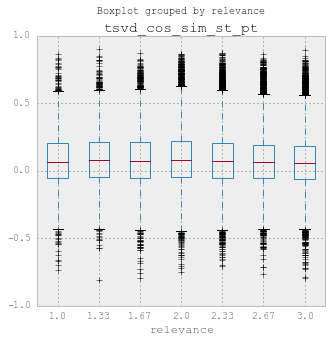

In [234]:
majoritize(df).boxplot(column='tsvd_cos_sim_st_pt', by='relevance', figsize=(5, 5))

In [230]:
tsvd_cos_sim_st_pd = []
for idx in range(st_tfidf_tsvd.shape[0]):
    if idx % 1000 == 0:
        print(idx)
    tsvd_cos_sim_st_pd.append(cosine_similarity(st_tfidf_tsvd[idx], pd_tfidf_tsvd[idx])[0][0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [231]:
df['tsvd_cos_sim_st_pd'] = tsvd_cos_sim_st_pd

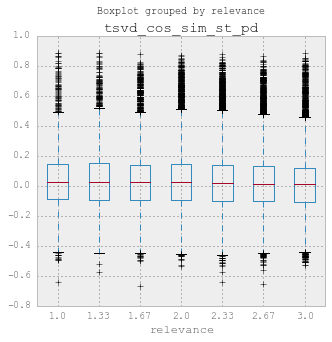

In [235]:
majoritize(df).boxplot(column='tsvd_cos_sim_st_pd', by='relevance', figsize=(5, 5))

## Word2Vec

In [77]:
# descriptions = list(df.product_description)
# title = list(df.product_title)
# sentences = descriptions + title
# sentences = [[word for word in word_tokenize(sentence)] for sentence in sentences]

# from collections import defaultdict

# frequency = defaultdict(int)
# for sentence in sentences:
#     for token in sentence:
#         frequency[token] += 1

# sentences = [[token for token in sentence if frequency[token] > 1] for sentence in sentences]

# model = word2vec.Word2Vec(sentences, size=100, window=5, min_count=5, workers=1)
# model.save('w2v.dump')

In [28]:
# w2v_model = word2vec.Word2Vec.load('w2v.dump')

# def w2v_similarity_wrapper(model, x, y):
#     try:
#         return model.similarity(x, y)
#     except:
#         return None
    
# def w2v_similarities(model, A, B):
#     sims = []
#     for x in A:
# #         print(B)
#         sims_ = [x for x in [w2v_similarity_wrapper(model, x, y) for y in B] if x is not None]
#         most = max(sims_) if sims_ else None
#         sims.append(most)
#     sims = list(filter(lambda x: x is not None, sims))
#     if not sims:
#         return .0, .0, .0
#     min_sim = min(sims)
#     max_sim = max(sims)
#     avg_sim = sum(sims) / float(len(A))
#     return (min_sim, max_sim, avg_sim)    

In [35]:
# df['sim_w2v_search_term_to_product_title_tuples'] = \
#     df.apply(lambda x: w2v_similarities(w2v_model, x['tokens_search_term'], x['tokens_product_title']), axis=1)

In [43]:
# df['sim_w2v_search_term_to_product_title_min'] = df['sim_w2v_search_term_to_product_title_tuples'].map(lambda x: x[0])
# df['sim_w2v_search_term_to_product_title_max'] = df['sim_w2v_search_term_to_product_title_tuples'].map(lambda x: x[1])
# df['sim_w2v_search_term_to_product_title_avg'] = df['sim_w2v_search_term_to_product_title_tuples'].map(lambda x: x[2])

In [ ]:
# df['sim_w2v_search_term_to_product_description_tuples'] = \
#     df.apply(lambda x: w2v_similarities(w2v_model, x['tokens_search_term'], x['tokens_product_description']), axis=1)

In [ ]:
# df['sim_w2v_search_term_to_product_description_min'] = df['sim_w2v_search_term_to_product_description_tuples'].map(lambda x: x[0])
# df['sim_w2v_search_term_to_product_description_max'] = df['sim_w2v_search_term_to_product_description_tuples'].map(lambda x: x[1])
# df['sim_w2v_search_term_to_product_description_avg'] = df['sim_w2v_search_term_to_product_description_tuples'].map(lambda x: x[2])

## Append

In [256]:
append = pd.read_csv('df_lev_dist_more_jaccard.csv', encoding='ISO-8859-1')

In [259]:
cols_to_append = [
    'query_in_title',
    'query_in_description',
    'query_last_word_in_title',
    'query_last_word_in_description',
    'word_in_title',
    'word_in_description',
    'word_in_brand',
    'ratio_title',
    'ratio_description',
    'ratio_brand',
    'lev_dist_to_product_title_min',
    'lev_dist_to_product_title_max',
    'lev_dist_to_product_title_sum',
    'lev_dist_to_product_description_min',
    'lev_dist_to_product_description_max',
    'lev_dist_to_product_description_sum'
]

In [260]:
for x in cols_to_append:
    df[x] = append[x]

## Export

In [261]:
cols_to_drop = [
    'tokens_search_term',
    'tokens_product_title',
    'tokens_product_description',
    'tokens_brand',
    'majority_relevance'
]
export_df = df.drop(cols_to_drop, axis=1)
print('Number of Features: ', len(export_df.columns.tolist()) - 7)

Number of Features:  100


In [252]:
export_df.head(3)

,id,product_title,product_uid,relevance,search_term,product_description,brand,tiv_cos_sim_st_pt_from_pt,tiv_cos_sim_st_pd_from_pd,len_search_term,len_product_title,len_product_description,len_brand,brand_encoded,flag_has_attr,jaccard_st_pt,jaccard_st_pd,jaccard_st_br,flag_st_in_pt,flag_st_in_pd,flag_st_in_br,num_st_in_pt,num_st_in_pd,num_st_in_br,ratio_st_in_pt,ratio_st_in_pd,ratio_st_in_br,st_tfidf_tsvd_0,st_tfidf_tsvd_1,st_tfidf_tsvd_2,st_tfidf_tsvd_3,st_tfidf_tsvd_4,st_tfidf_tsvd_5,st_tfidf_tsvd_6,st_tfidf_tsvd_7,st_tfidf_tsvd_8,st_tfidf_tsvd_9,pt_tfidf_tsvd_0,pt_tfidf_tsvd_1,pt_tfidf_tsvd_2,pt_tfidf_tsvd_3,pt_tfidf_tsvd_4,pt_tfidf_tsvd_5,pt_tfidf_tsvd_6,pt_tfidf_tsvd_7,pt_tfidf_tsvd_8,pt_tfidf_tsvd_9,pd_tfidf_tsvd_0,pd_tfidf_tsvd_1,pd_tfidf_tsvd_2,pd_tfidf_tsvd_3,pd_tfidf_tsvd_4,pd_tfidf_tsvd_5,pd_tfidf_tsvd_6,pd_tfidf_tsvd_7,pd_tfidf_tsvd_8,pd_tfidf_tsvd_9,tsvd_cos_sim_st_pt,tsvd_cos_sim_st_pd,st_tfidf_tsvd_10,st_tfidf_tsvd_11,st_tfidf_tsvd_12,st_tfidf_tsvd_13,st_tfidf_tsvd_14,st_tfidf_tsvd_15,st_tfidf_tsvd_16,st_tfidf_tsvd_17,st_tfidf_tsvd_18,st_tfidf_tsvd_19,pt_tfidf_tsvd_10,pt_tfidf_tsvd_11,pt_tfidf_tsvd_12,pt_tfidf_tsvd_13,pt_tfidf_tsvd_14,pt_tfidf_tsvd_15,pt_tfidf_tsvd_16,pt_tfidf_tsvd_17,pt_tfidf_tsvd_18,pt_tfidf_tsvd_19,pd_tfidf_tsvd_10,pd_tfidf_tsvd_11,pd_tfidf_tsvd_12,pd_tfidf_tsvd_13,pd_tfidf_tsvd_14,pd_tfidf_tsvd_15,pd_tfidf_tsvd_16,pd_tfidf_tsvd_17,pd_tfidf_tsvd_18,pd_tfidf_tsvd_19,tiv_cos_sim_st_pt_from_st,tiv_cos_sim_st_pd_from_st
0,2,simpson strong tie 12 gaug angl,100001,3.0,angl bracket,not onli do angl make joint stronger they also...,simpson strong tie,0.098972,0.042391,2,6,135,3,1000,1,0.142857,0.297297,0.375,0,0,0,1,1,0,0.5,0.5,0.0,0.002581,0.002476,0.002105,0.010208,0.000414,-0.004085,-0.000676,-0.003501,0.020349,0.008458,0.027834,-0.004397,0.009356,-0.005977,-0.001123,0.015347,0.021875,0.010590,-0.016595,0.009619,0.063502,-0.037022,-0.019762,-0.009397,-0.004174,0.001824,-0.039904,0.001151,0.049458,-0.021712,-0.358421,-0.008858,0.000215,0.011668,0.001485,0.016781,-0.012570,-0.010925,0.022703,0.010636,0.023691,0.004590,-0.022955,-0.003192,0.004204,0.002126,0.009005,-0.027243,0.026662,-0.026422,-0.104726,0.008874,-0.016560,0.000179,-0.020996,-0.04224,0.011451,0.030388,0.008129,-0.006199,0.014950,-0.017557,0.137956,0.117150
1,3,simpson strong tie 12 gaug angl,100001,2.5,l bracket,not onli do angl make joint stronger they also...,simpson strong tie,0.000000,0.000000,2,6,135,3,1000,1,0.000000,0.243243,0.250,0,0,0,0,0,0,0.0,0.0,0.0,0.003524,0.004073,0.001405,0.017381,-0.001632,-0.007845,-0.001499,-0.010721,0.036691,0.017112,0.027834,-0.004397,0.009356,-0.005977,-0.001123,0.015347,0.021875,0.010590,-0.016595,0.009619,0.063502,-0.037022,-0.019762,-0.009397,-0.004174,0.001824,-0.039904,0.001151,0.049458,-0.021712,-0.389182,0.007202,-0.003119,0.022232,0.003221,0.026485,-0.023491,-0.020745,0.043293,0.021111,0.048846,0.011549,-0.022955,-0.003192,0.004204,0.002126,0.009005,-0.027243,0.026662,-0.026422,-0.104726,0.008874,-0.016560,0.000179,-0.020996,-0.04224,0.011451,0.030388,0.008129,-0.006199,0.014950,-0.017557,0.000000,0.000000
2,9,behr premium textur deckov 1gal. #sc 141 tugbo...,100002,3.0,deck over,behr premium textur deckov is an innov solid c...,behr premium textur deckov,0.000000,0.090275,2,12,169,4,1010,1,0.000000,0.210526,0.500,0,0,0,0,1,0,0.0,0.5,0.0,0.010247,0.005425,-0.000586,0.016702,-0.012679,-0.015642,-0.012186,-0.026668,0.047811,-0.006619,0.012572,-0.001650,-0.000029,0.003020,-0.009497,0.012161,-0.030995,-0.020599,0.023260,-0.004258,0.100527,-0.110985,0.239911,0.041422,0.017161,-0.021333,0.013920,-0.080788,0.022276,-0.002187,0.170551,0.085309,0.071808,0.003138,0.042883,-0.026379,-0.042348,-0.002232,0.047848,0.062268,0.023312,0.069516,-0.014685,-0.046375,0.114831,-0.014295,0.042351,0.002611,-0.006461,-0.004805,0.020214,-0.006825,-0.004309,-0.011836,-0.000144,-0.01578,-0.006489,0.031753,0.015803,0.001863,0.004388,-0.018870,0.000000,0.172419


In [262]:
export_df.to_csv('./df_new_419_3.csv')